# Fast Neural Network + Yolact

Reference:
* [Yolact](https://github.com/dbolya/yolact)
* [Fast Neural Style](https://github.com/pytorch/examples/tree/master/fast_neural_style)
* [TorchScript](https://huggingface.co/transformers/torchscript.html)

In [1]:
import os, json, sys
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/NYU/Deep\ Learning/project

/content/gdrive/My Drive/NYU/Deep Learning/project


## Package Install

### Install Yolact

In [ ]:
! git clone https://github.com/dbolya/yolact.git

Cloning into 'yolact'...
remote: Enumerating objects: 2936, done.
remote: Total 2936 (delta 0), reused 0 (delta 0), pack-reused 2936
Receiving objects: 100% (2936/2936), 21.20 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (2003/2003), done.


Download base Yolact model: https://drive.google.com/file/d/1yp7ZbbDwvMiFJEq4ptVKTYTI2VeRDXl0

### Install Fast Neural Style

In [ ]:
! git clone https://github.com/pytorch/examples.git 
! cp -r examples/fast_neural_style fast_neural_style
! rm -r examples
! python fast_neural_style/download_saved_models.py
! rm -r saved_models.zip
! mv -v saved_models/*.pth model

Cloning into 'examples'...
remote: Enumerating objects: 2846, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 2846 (delta 3), reused 2 (delta 0), pack-reused 2831
Receiving objects: 100% (2846/2846), 39.17 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (1425/1425), done.
Checking out files: 100% (136/136), done.
100% 23.9M/23.9M [00:00<00:00, 120MB/s]


### Package Import

To import the customize package in different file, we choose to change the directory on the file loaded

In [3]:
import os, json, tqdm, argparse, sys, argparse, time, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from PIL import Image

from torchvision import transforms

In [4]:
%cd yolact
from eval import *
from data import cfg, set_cfg, set_dataset
import os, time

from yolact import Yolact
import torch.backends.cudnn as cudnn
%cd ../

/content/gdrive/My Drive/NYU/Deep Learning/project/yolact
/content/gdrive/My Drive/NYU/Deep Learning/project


In [5]:
%cd fast_neural_style/neural_style
from transformer_net import TransformerNet
from vgg import Vgg16
%cd ../../

/content/gdrive/My Drive/NYU/Deep Learning/project/fast_neural_style/neural_style
/content/gdrive/My Drive/NYU/Deep Learning/project


## Join Model

### Basic Setting
Select the model and set the image directory

In [6]:
parser = {
    "cuda":True,
    "content_image":"data/anna-kendrick.jpg",
    "content_scale":None,
    
    "yolact_model":"model/yolact_base_54_800000.pth",
    "style_model":"model/mosaic.pth", # candy.pth, rain_princess.pth, udnie.pth, mosaic.pth
    "torchscript_save_model":"model/yolact_style_mosaic.pth", # candy.pth, rain_princess.pth, udnie.pth, mosaic.pth
}

args = argparse.Namespace(**parser)

### Load Image
This is used to preprocessing the image to the use type for the model

In [7]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img

def img_pre(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.Resize((800, 1200)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)
    return content_image

### Load Model

The function for `load_style_model` is used to load the style transfer model; `load_segment_model` is used to load the Yolact model. Since we only have one GPU while using colab, we concatenate two models in one using `PartialTransformer` and further using the post process function in the Yolact to generate the output 0-1 mask. With the mask, 0 is used to preserve the original image input, 1 is used to extract the generated image. With the combination, we can produce the result.<br>

Note:
1. For the segment output, we style transfer all the object that has been observed by the model
2. For convenience, the default using the model here has the available GPU. 

In [8]:
def load_style_model(args):
    device = torch.device("cuda" if args.cuda else "cpu")
    style_model = TransformerNet()
    state_dict = torch.load(args.style_model)
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device)
    return style_model

def load_segment_model(args):
    yolact_model = Yolact()
    yolact_model.load_weights(args.yolact_model)
    yolact_model = yolact_model.cuda()
    return yolact_model

class PartialTransformer(torch.nn.Module):
    def __init__(self, args):
        super(PartialTransformer, self).__init__()
        self.sty_model = load_style_model(args)
        self.seg_model = load_segment_model(args)
        self.seg_model.detect.use_fast_nms = True
        self.seg_model.detect.use_cross_class_nms = False

    def forward(self, content_img):
        # ====== style transfer ======
        output = self.sty_model(content_img)

        # ====== real-time segmentation ======
        cudnn.fastest = True
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
        frame = content_img.squeeze(0).permute(1, 2, 0)
        batch = FastBaseTransform()(frame.unsqueeze(0))
        res = self.seg_model(batch)

            # post process -> get 0-1 mask
        with timer.env('Postprocess'):
            save = cfg.rescore_bbox
            cfg.rescore_bbox = True
            cfg.mask_proto_debug = False
            t = postprocess(res, frame.shape[1], frame.shape[0], visualize_lincomb = False, crop_masks = False, score_threshold = 0.15)
        mask = t[3].sum(axis=0).clamp(min=0, max=1).long()

        # ====== merge two model output ======
        original_img = frame
        transferred_img = output.squeeze(0).permute(1, 2, 0)
        segmentation_mask = mask.unsqueeze(2)

        final_result = (transferred_img*segmentation_mask + original_img*(1-segmentation_mask)).long()
        return final_result

In [9]:
partial_transformer = PartialTransformer(args)

/usr/local/lib/python3.7/dist-packages/torch/jit/_recursive.py:202: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/usr/local/lib/python3.7/dist-packages/torch/jit/_recursive.py:202: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/usr/local/lib/python3.7/dist-packages/torch/jit/_recursive.py:202: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [122]:
partial_transformer.eval()
with torch.no_grad():
    content_img = img_pre(args)
    result = partial_transformer(content_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


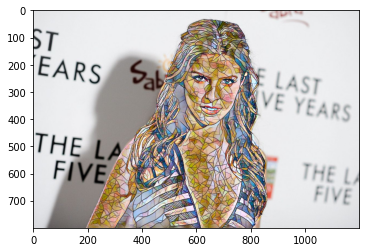

In [123]:
plt.imshow(result.cpu().numpy())

# TorchScript

Normally, load model need model structure and weight. Torchscript is the way to store the whole model in the script with the model setting. The saved model don't need to pre-install the required package. Everything is stored in the script. Only provided the related input to the model and it will return the corresponding output

Save model using torchscript

In [124]:
traced_model = torch.jit.trace(partial_transformer, [content_img])

/content/gdrive/My Drive/NYU/Deep Learning/project/yolact/utils/augmentations.py:626: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  self.mean = torch.Tensor(MEANS).float().cuda()[None, :, None, None]
/content/gdrive/My Drive/NYU/Deep Learning/project/yolact/utils/augmentations.py:627: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  self.std  = torch.Tensor( STD ).float().cuda()[None, :, None, None]
/content/gdrive/My Drive/NYU/Deep Learning/project/yolact/yolact.py:220: TracerWar

In [126]:
torch.jit.save(traced_model, args.torchscript_save_model)

Load torchscipt model

In [127]:
loaded_model = torch.jit.load(args.torchscript_save_model)
loaded_model.eval()

RecursiveScriptModule(
  original_name=PartialTransformer
  (sty_model): RecursiveScriptModule(
    original_name=TransformerNet
    (conv1): RecursiveScriptModule(
      original_name=ConvLayer
      (reflection_pad): RecursiveScriptModule(original_name=ReflectionPad2d)
      (conv2d): RecursiveScriptModule(original_name=Conv2d)
    )
    (in1): RecursiveScriptModule(original_name=InstanceNorm2d)
    (conv2): RecursiveScriptModule(
      original_name=ConvLayer
      (reflection_pad): RecursiveScriptModule(original_name=ReflectionPad2d)
      (conv2d): RecursiveScriptModule(original_name=Conv2d)
    )
    (in2): RecursiveScriptModule(original_name=InstanceNorm2d)
    (conv3): RecursiveScriptModule(
      original_name=ConvLayer
      (reflection_pad): RecursiveScriptModule(original_name=ReflectionPad2d)
      (conv2d): RecursiveScriptModule(original_name=Conv2d)
    )
    (in3): RecursiveScriptModule(original_name=InstanceNorm2d)
    (res1): RecursiveScriptModule(
      original_name=

Run torchscript model result

In [129]:
# st = time.time()
# loaded_result = loaded_model(content_img)
# en = time.time()

# print(en-st)
# plt.imshow(loaded_result.cpu().numpy())